In [1]:
using Pkg; Pkg.instantiate(); Pkg.precompile()

Precompiling project...


In [2]:
using Random; Random.seed!(1234);

# Cookie-cutter

In this tutorial, we illustrate a simplistic, yet useful procedure for generating geostatistical realizations of the subsurface taking into account various lithology. The procedure known in the literature as "cookie-cutter" [Begg 1992](https://www.onepetro.org/conference-paper/SPE-24698-MS) consists of first simulating a categorical variable (a.k.a. the facies) and then populating each simulated category with a separate simulation solver.

Regardless of the artifacts that the procedure may create, it is very useful for building complex geological models that show strong contrasts (e.g. highly permeable channels within less permeable media). These contrasts are relevant for flow simulation studies and other applications.

## Problem definition

We define an unconditional simulation problem for simplicity, but the same steps apply in the presence of data.

In [3]:
using GeoStats

𝒟 = RegularGrid(100, 100)

vars = (:facies => Int, :porosity => Float64)

problem = SimulationProblem(𝒟, vars, 3)

2D SimulationProblem (unconditional)
  domain:    100×100 RegularGrid{Float64,2}
  variables: porosity (Float64) and facies (Int64)
  N° reals:  3

In this problem, we will simulate the `facies` variable and use its realizations to guide the simulation of `porosity`.

## Solving the problem

We define the facies simulation solver based on a training image that has two categories:

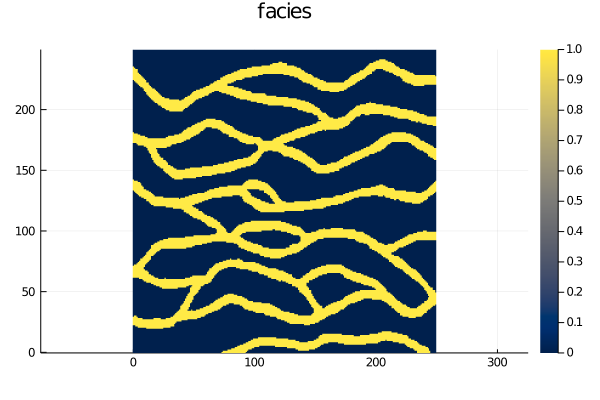

In [4]:
using GeoStatsImages
using Plots; gr(c=:cividis)

ℐ = geostatsimage("Strebelle")

plot(ℐ)

Image quilting is a good default for training-image-based simulation:

In [5]:
using ImageQuilting

# convert spatial variable to Julia array
TI = reshape(ℐ[:facies], size(domain(ℐ)))

fsolver = ImgQuilt(:facies => (TI=TI, tilesize=(30,30)))

ImgQuilt
  └─facies
    └─TI ⇨ [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
    └─tilesize ⇨ (30, 30)
    └─path ⇨ :raster
    └─soft ⇨ Any[]
    └─tol ⇨ 0.1


Because there are two categorical values (0 and 1), we define two solvers:

In [6]:
using DirectGaussianSimulation

psolver₀ = DirectGaussSim(
    :porosity => (variogram=SphericalVariogram(range=20., sill=.2),)
)

psolver₁ = DirectGaussSim(
    :porosity => (variogram=SphericalVariogram(range=20., distance=Ellipsoidal([10.,1.],[0.])),)
);

Finally, we create the cookie-cutter procedure by specifying the master (a.k.a. facies) solver, and a solver for each categorical value:

In [7]:
solver = CookieCutter(fsolver, Dict(0 => psolver₀, 1 => psolver₁))

CookieCutter
  └─facies ⇨ ImgQuilt
    └─0 ⇨ DirectGaussSim
    └─1 ⇨ DirectGaussSim


GeoStats.jl will generate the realizations in parallel as usual for each solver, and then it will combine the results into a single solution:

In [8]:
solution = solve(problem, solver)

2D SimulationSolution
  domain: 100×100 RegularGrid{Float64,2}
  variables: porosity and facies
  N° reals:  3

We can plot each variable to confirm that the procedure was effective:

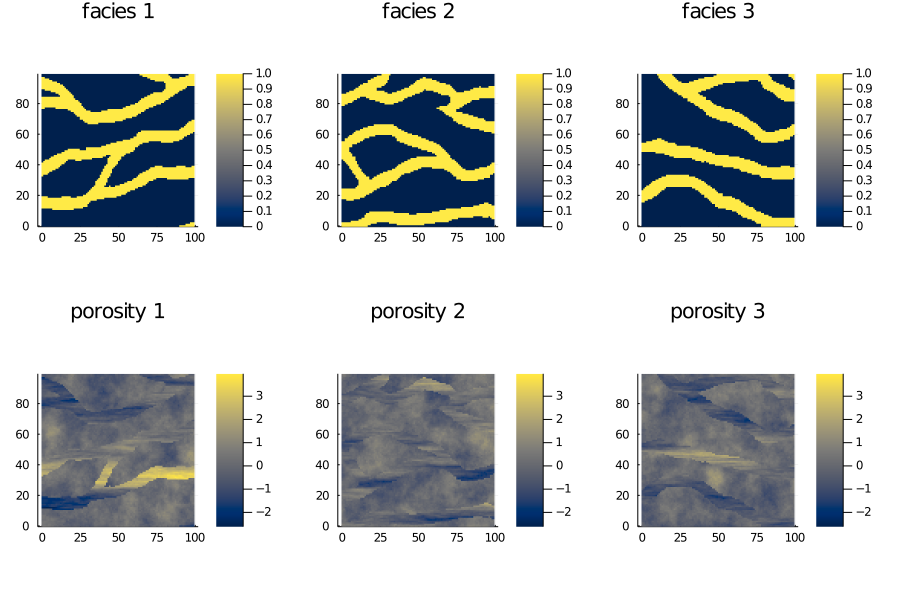

In [9]:
plot(solution, size=(900,600))

## Conclusions

- The cookie-cutter procedure in GeoStats.jl gives users the ability to create very complex combinations of patterns that are difficult to generate otherwise with a single simulation algorithm.

- Any simulation solver adhering to the interface proposed in the framework can be used as a building block for cookie-cutter. This feature opens the door to a whole new set of models, which cannot be generated in other software.